# Capstone Project - The Battle of Neighbourhoods

## Import Libraries

We will import all the necessary libraries that will require to read and process the data.

In [1]:
import pandas as pd                   #to read the data and perform basic dataframe operation
from geopy import geocoders           #installing geopy for geolocating
import folium                         #for plotting on map
from sklearn.cluster import KMeans    #importing KMeans algorithm
import requests                       #for requesting to url
import numpy as np                    #for mathematical operations

#importing modules relating to matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Librairies Imported !!')

Librairies Imported !!


# Exploring Dataset

For this project, we don't need any other dataset for this project, to get location we just need to provide the name of the location and the coordinates of the location will be extracted with the help of geopy library.

In [2]:
#assigning number of days to tour also the number of clusters
k = 5
address = 'New Delhi'    #location we want to visit

#extracting location and storing it for further use
geolocator = geocoders.Nominatim(user_agent='Delhi_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Visualizing on map

With the help of Folium library we can visualize the location we are travelling to

In [3]:
address_map = folium.Map(location = [latitude,longitude],zoom_start =11)
address_map

# Extracting nearby values

With the help of Foursquare API we can extract any kind of venues nearby to the location of our interest.

In [4]:
# The following function retrieves the venues given the names and coordinates and stores it into dataframe.
def getNearbyVenues(names, latitudes, longitudes, radius=500,categoryIds = ''):
    try: 
        venues_list=[]
        #for name, lat, long in zip(names, latitudes, longitudes):
            #print(name)
            # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT)
        if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

        # make the GET request
        response = requests.get(url).json()
        results = response["response"]['venues']

          # return only relevant information for each nearby venue
        for v in results:
            success = False
            try:
                category = v['categories'][0]['name']
                success = True
            except:
                pass

            if success:
                venues_list.append([(
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],
                    v['categories'][0]['name']
                 )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']

    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

# Defining Foursquare credentials

In [5]:
CLIENT_ID = 'GIW5UMML5MUTOZI20KD45YDCPG0QRYXMWVTEXGUL2UZNBSES' # your Foursquare ID
CLIENT_SECRET = '2M4VMXELZZBZDPFCX2CP2EZH2GNEOPQHMX2BKRWLT5LY3RRE' # your Foursquare Secret
VERSION = '20200406' # Foursquare API version
LIMIT = 30
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('LIMIT:' + str(LIMIT))
print('Radius:' + str(radius))

Your credentails:
CLIENT_ID: GIW5UMML5MUTOZI20KD45YDCPG0QRYXMWVTEXGUL2UZNBSES
CLIENT_SECRET:2M4VMXELZZBZDPFCX2CP2EZH2GNEOPQHMX2BKRWLT5LY3RRE
LIMIT:30
Radius:500


As we will be planning to visit the famous landmaks we will use monuments/landmark categoryID which is 4bf58dd8d48988d12d941735

In [6]:
address_venues = getNearbyVenues(names = address,latitudes=latitude,longitudes=longitude
                                 ,radius=50000, categoryIds='4bf58dd8d48988d12d941735')
address_venues.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rashtrapati Bhavan | राष्ट्रपति भवन (Rashtrapa...,28.614133,77.209193,Monument / Landmark
1,Lok Sabha,28.613957,77.208862,Monument / Landmark
2,India Gate | इंडिया गेट (India Gate),28.612796,77.229207,Monument / Landmark
3,Humayun’s Tomb | हुमायूँ का मकबरा (Humayun’s T...,28.593197,77.246047,Monument / Landmark
4,Qutub Minar | क़ुतुब मीनार (Qutub Minar),28.525265,77.186593,Monument / Landmark


In [7]:
address_venues.shape    #looking at the shape of the venues we have obtained

(28, 4)

In [8]:
address_venues.groupby(by = 'Venue Category')['Venue'].count()

Venue Category
City Hall               1
Concert Hall            1
Historic Site           1
History Museum          1
Market                  1
Monument / Landmark    21
Music Venue             1
Spiritual Center        1
Name: Venue, dtype: int64

Let's plot the coordinates on a folium map

In [9]:
def addToMap(df, color, existingMap):
    for lat, lng, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Venue'], df['Venue Category']):
        label = '{} ({})'.format(venue, venueCat)      #label of the point
        label = folium.Popup(label, parse_html=True)   #pops up and display the label when clicked
        folium.CircleMarker(                           #defining the circle marker for each coordinate in the dataframe 
            [lat, lng],                                          # providing coordinates
            radius=3,                                            #radius of the marker
            popup=label,                                         
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [10]:
addToMap(address_venues,'red',address_map)
address_map

# Performing clustering on the coordinates

In [11]:
X = address_venues[['Venue Latitude','Venue Longitude']]     #creating X dataset for clustering
X.head()

,Venue Latitude,Venue Longitude
0,28.614133,77.209193
1,28.613957,77.208862
2,28.612796,77.229207
3,28.593197,77.246047
4,28.525265,77.186593


In [12]:
# Initializing clustering algorithms with 'K' number of clusters where K is the total number of days to visit
cluster = KMeans(n_clusters=k,
    init='k-means++',)

In [13]:
cluster.fit(X)    #fitting the coordinates in the model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
address_venues.insert(0, 'Cluster Labels', cluster.labels_) #adding the labels into the dataframe
address_venues.head()

,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Rashtrapati Bhavan | राष्ट्रपति भवन (Rashtrapa...,28.614133,77.209193,Monument / Landmark
1,0,Lok Sabha,28.613957,77.208862,Monument / Landmark
2,0,India Gate | इंडिया गेट (India Gate),28.612796,77.229207,Monument / Landmark
3,0,Humayun’s Tomb | हुमायूँ का मकबरा (Humayun’s T...,28.593197,77.246047,Monument / Landmark
4,3,Qutub Minar | क़ुतुब मीनार (Qutub Minar),28.525265,77.186593,Monument / Landmark


# Visualizing the clustered coordinates on the map

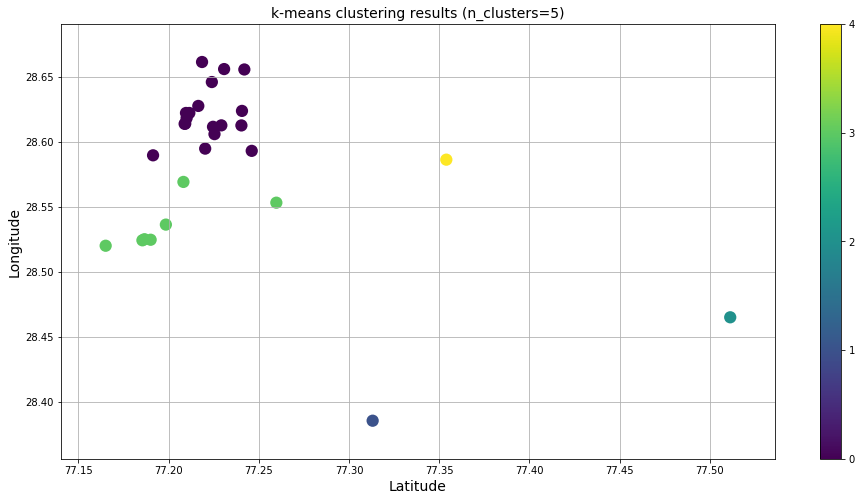

In [15]:
fig = plt.figure(figsize=(16,8))    #initializing figure with proper size
#plotting a scatter plot for the coordiantes with Longitude on X axis and Latitude on Y axis
plt.scatter(address_venues['Venue Longitude'], address_venues['Venue Latitude'], c=address_venues['Cluster Labels'],
              s=150, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,4,5))
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('k-means clustering results (n_clusters=5)', fontsize=14)
plt.grid()
plt.show()

In [16]:
# create map
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(address_venues['Venue Latitude'], address_venues['Venue Longitude'], address_venues['Venue'], address_venues['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Converting the coordinates into a dataframe

In [17]:
final_address_venue = address_venues[['Venue','Venue Category','Cluster Labels']].sort_values(by =['Cluster Labels']).reset_index()
final_address_venue = final_address_venue.drop(['index'],axis =1)
final_address_venue = final_address_venue.rename(columns = {'Cluster Labels':'Day'})
final_address_venue['Day'] += 1
final_address_venue.head()

,Venue,Venue Category,Day
0,Rashtrapati Bhavan | राष्ट्रपति भवन (Rashtrapa...,Monument / Landmark,1
1,Jantar Mantar,Historic Site,1
2,Ajmeri Gate,Monument / Landmark,1
3,ARCHAELOGICAL SURVEY OF INDIA (A.S.I),Monument / Landmark,1
4,Bada Gumbad,Monument / Landmark,1


In [18]:
final_address_venue.to_csv(r'final_df.csv')     #saving dataframe as a csv file in the directory

#### With the help of  this approach, one can easily decide where to and when to visit in their vacation based on their location and the number of days of vacation

# Thank You